✅ Dataset loaded successfully.
📊 Dataset: 3005 records × 34 variables

📋 Available columns:
  - 'DOI'
  - 'Judul'
  - 'Tahun'
  - 'Jurnal/Source'
  - 'Volume/Issue'
  - 'Halaman'
  - 'Art_No'
  - 'Tipe_Dokumen'
  - 'Bahasa'
  - 'Jumlah_Sitasi'
  - 'Daftar_Referensi'
  - 'Nama_Penulis'
  - 'Author_Full'
  - 'Author_ID'
  - 'Email'
  - 'Afiliasi'
  - 'Afiliasi_Detail'
  - 'Kata_Kunci_Penulis'
  - 'Kata_Kunci_Indeks'
  - 'Abstrak'
  - 'Kategori_Jurnal'
  - 'Open_Access'
  - 'Publisher'
  - 'ISSN_ISBN'
  - 'Sponsor_Funder'
  - 'Konferensi'
  - 'Indeksasi_DB'
  - 'Jumlah_Referensi'
  - 'Judul_norm'
  - 'Penulis_pertama'
  - 'dedup_key'
  - 'Negara'
  - 'Negara_norm'
  - 'Negara_norm_sebelum'

🔍 Using author column: 'Penulis_pertama'
🔍 Using citation column: 'Jumlah_Sitasi'
🔍 Using year column: 'Tahun'
🔍 Using country column: 'Negara_norm'
🧹 Cleaned dataset: 2990 publications

🔬 ANALYSIS 1: BASIC ACADEMIC INEQUALITY
--------------------------------------------------
                  Metric 

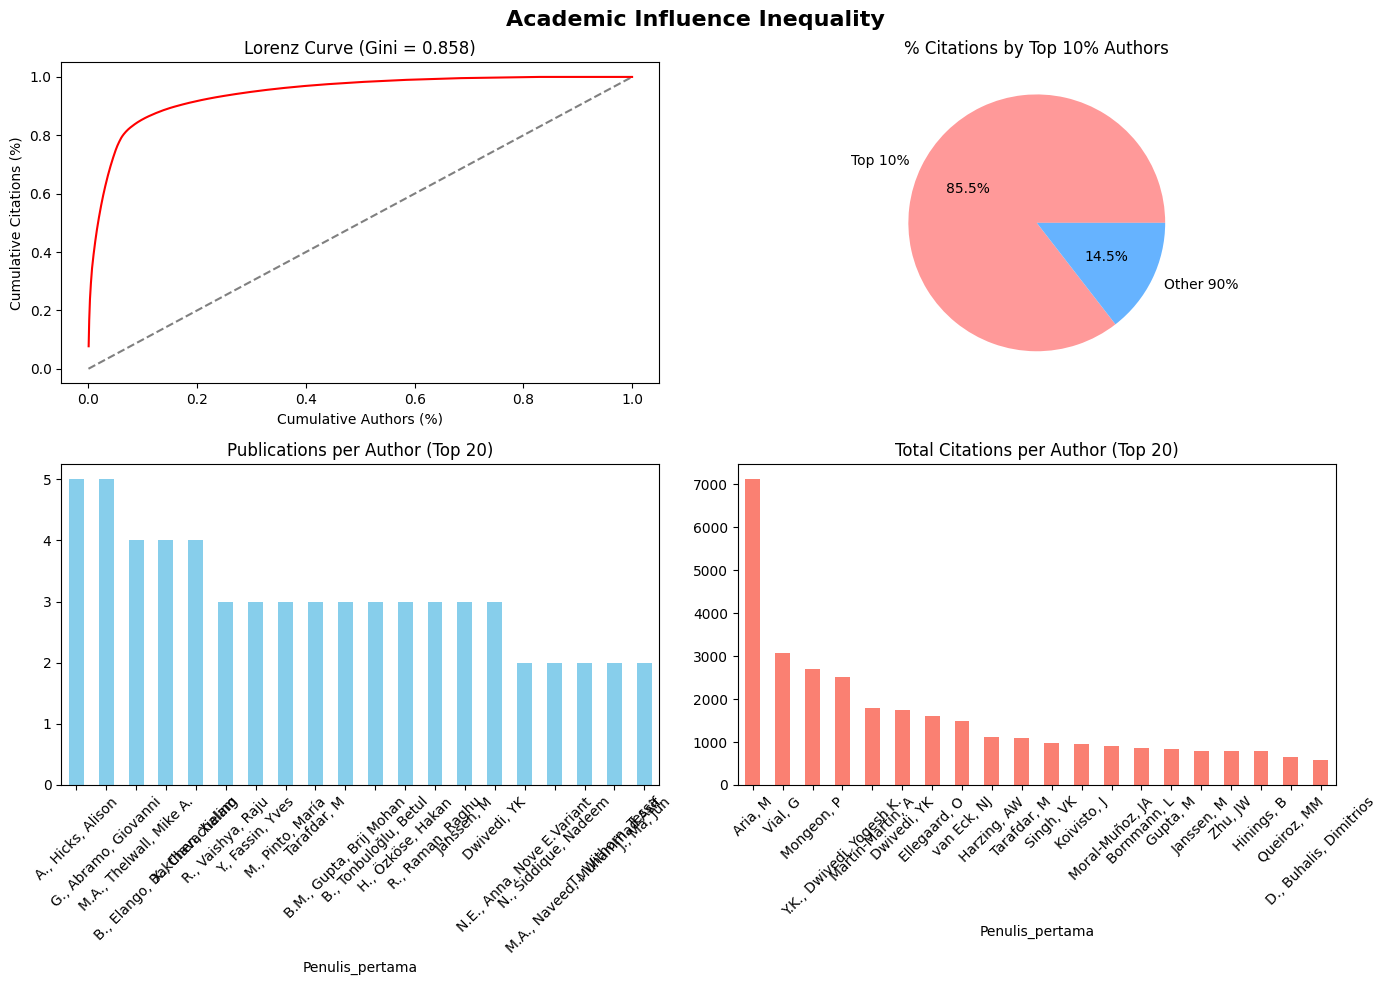

✅ Basic analysis saved to:
  - ../output/tables/inequality_summary.csv
  - ../output/figures/academic_inequality_analysis.png

🔬 ANALYSIS 2: TEMPORAL TRENDS (2015–2024)
--------------------------------------------------
📅 Period 1 (2015–2019): 104 publications
📅 Period 2 (2020–2024): 2885 publications
                Metric 2015–2019 2020–2024
      Gini Coefficient      0.46      0.78
Top 10% Citation Share     42.4%     74.4%
     Estimated h-index       102        83
  Total Unique Authors       102      2776


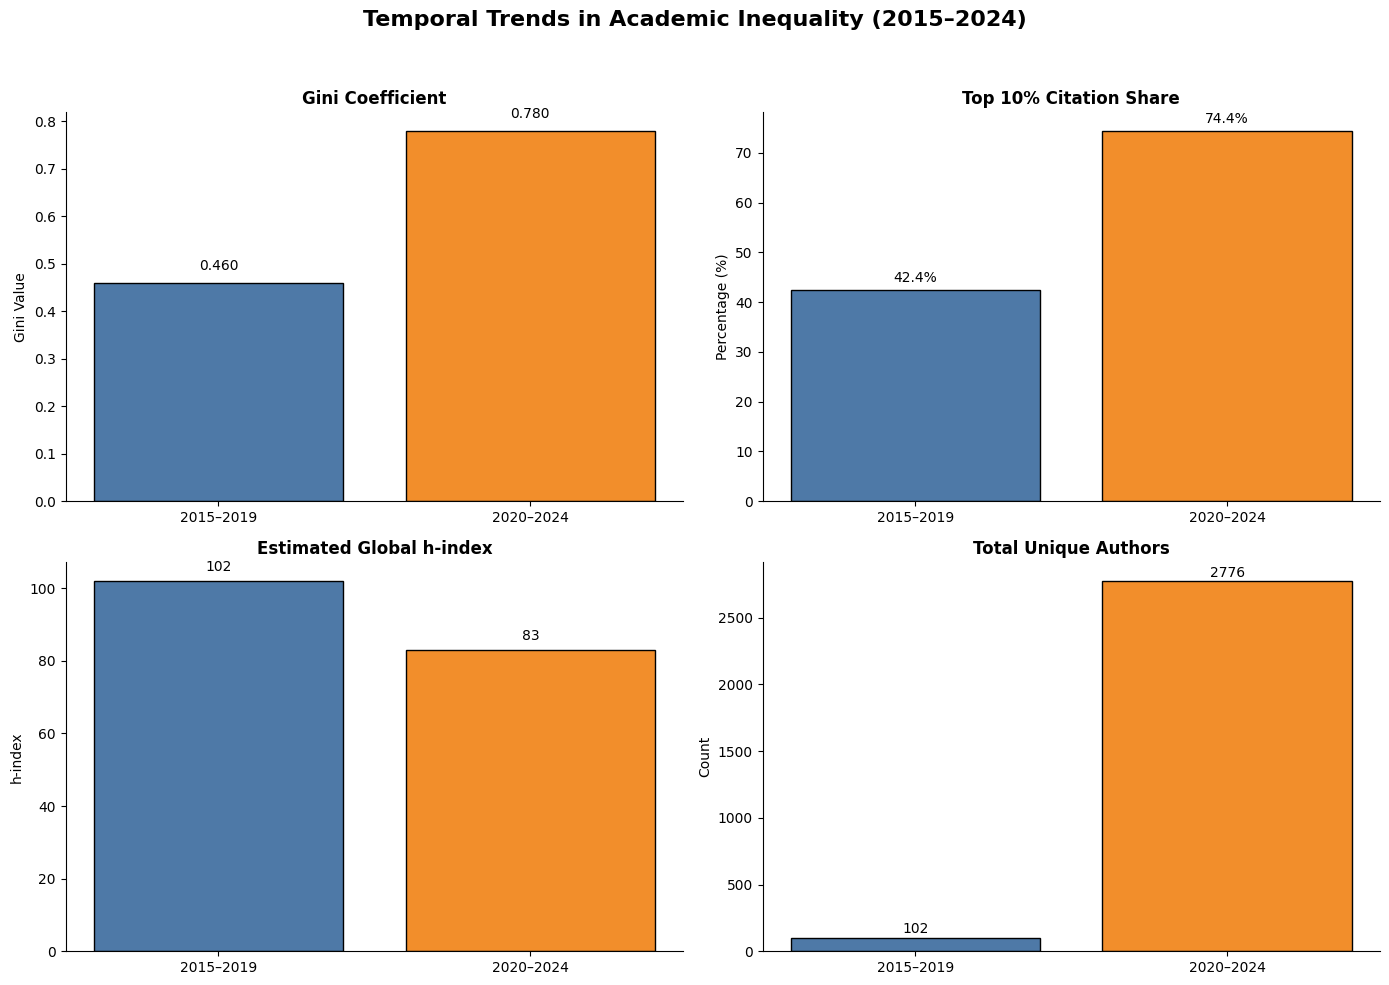

✅ Temporal analysis saved to:
  - ../output/tables/temporal_inequality_trends.csv
  - ../output/figures/academic_inequality_trends.png

🔬 ANALYSIS 3: GLOBAL NORTH vs. GLOBAL SOUTH
--------------------------------------------------
🌍 Mapped 1958 publications to Global North/South
  - Global North: 829 publications
  - Global South: 1129 publications
               Metric     Value
       Mann-Whitney U  538277.5
              p-value  5.50e-09
        Cliff's Delta      0.15
          Effect Size     Small
Median Citations (GN)       5.0
Median Citations (GS)       3.0


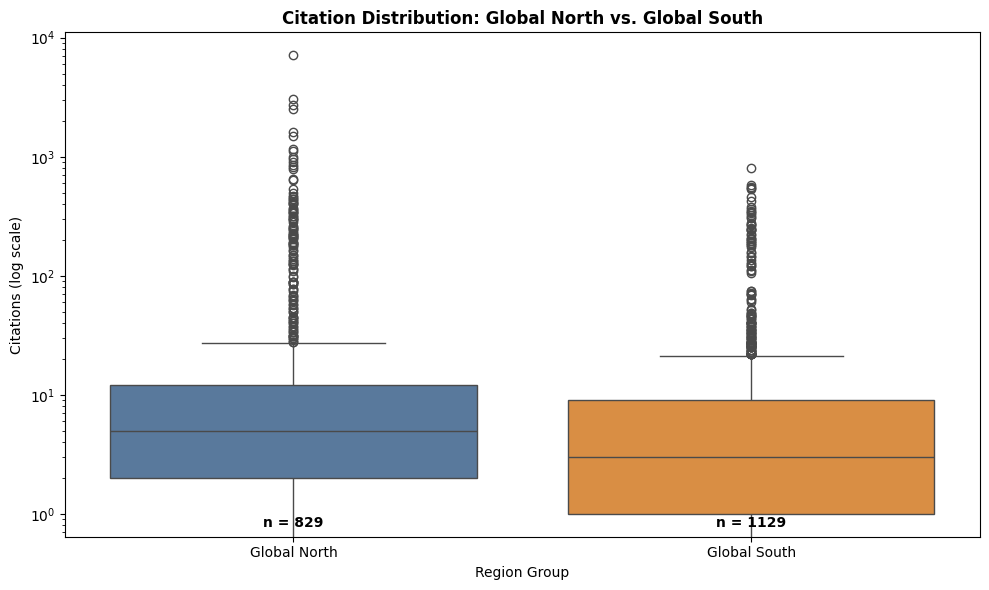

✅ North-South analysis saved to:
  - ../output/tables/north_south_citation_inequality_stats.csv
  - ../output/figures/north_south_citation_distribution.png

🎉 ALL ANALYSES COMPLETED!
📁 Outputs saved to:
  - ../output/figures/
  - ../output/tables/


In [2]:
# -*- coding: utf-8 -*-
"""
RUN ALL ANALYSES — FULL REPRODUCIBILITY
This notebook reproduces all tables and figures using your actual column names:
- Author: 'Penulis_pertama'
- Citations: 'Jumlah_Sitasi'
- Year: 'Tahun'
- Country: 'Negara_norm'

Outputs saved to:
  - ../output/figures/
  - ../output/tables/
"""

# =============================================================================
# CELL 1: SETUP — LOAD DATA & DEFINE PATHS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings("ignore")

# Set paths (relative to notebooks/)
input_file = "../data/processed/processed_publications_for_mertonian_analysis.csv"
output_figures = "../output/figures"
output_tables = "../output/tables"

# Create output folders
os.makedirs(output_figures, exist_ok=True)
os.makedirs(output_tables, exist_ok=True)

# Load data
try:
    data = pd.read_csv(input_file)
    print("✅ Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"Input file not found: {input_file}")

print(f"📊 Dataset: {data.shape[0]} records × {data.shape[1]} variables")
print("\n📋 Available columns:")
for col in data.columns:
    print(f"  - '{col}'")
print()

# =============================================================================
# CELL 2: HARD-CODE COLUMN NAMES (based on your actual data)
# =============================================================================
# Use your exact column names
AUTHOR_COL = 'Penulis_pertama'
CITATION_COL = 'Jumlah_Sitasi'
YEAR_COL = 'Tahun'
COUNTRY_COL = 'Negara_norm'

# Validate presence
missing = []
if AUTHOR_COL not in data.columns:
    missing.append(AUTHOR_COL)
if CITATION_COL not in data.columns:
    missing.append(CITATION_COL)
if missing:
    raise KeyError(f"Required columns missing: {missing}")

print(f"🔍 Using author column: '{AUTHOR_COL}'")
print(f"🔍 Using citation column: '{CITATION_COL}'")
if YEAR_COL in data.columns:
    print(f"🔍 Using year column: '{YEAR_COL}'")
if COUNTRY_COL in data.columns:
    print(f"🔍 Using country column: '{COUNTRY_COL}'")

# Clean and prepare data
data_clean = data.copy()
data_clean[CITATION_COL] = pd.to_numeric(data_clean[CITATION_COL], errors='coerce')
data_clean = data_clean.dropna(subset=[AUTHOR_COL, CITATION_COL])
data_clean = data_clean[data_clean[CITATION_COL] >= 0]
data_clean[AUTHOR_COL] = data_clean[AUTHOR_COL].astype(str).str.strip()
data_clean = data_clean[data_clean[AUTHOR_COL] != '']

print(f"🧹 Cleaned dataset: {len(data_clean)} publications")
print("="*70)

# =============================================================================
# CELL 3: BASIC INEQUALITY ANALYSIS (Gini, Top 10%, h-index)
# =============================================================================
print("\n🔬 ANALYSIS 1: BASIC ACADEMIC INEQUALITY\n" + "-"*50)

def compute_gini(x):
    x = np.array(x)
    if len(x) == 0 or x.sum() == 0:
        return 0.0
    x = x[x > 0]
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * x)) / (n * np.sum(x))

# Aggregate by first author
citations_per_author = data_clean.groupby(AUTHOR_COL)[CITATION_COL].sum().sort_values(ascending=False).values
gini_coef = compute_gini(citations_per_author)

total_citations = citations_per_author.sum()
total_authors = len(citations_per_author)
n_top_10 = max(1, int(0.1 * total_authors))
pct_top_10 = (citations_per_author[:n_top_10].sum() / total_citations) * 100
h_index = np.sum(citations_per_author >= np.arange(1, len(citations_per_author) + 1))

# Save results
basic_results = pd.DataFrame({
    'Metric': [
        'Gini Coefficient',
        '% Citations by Top 10%',
        'Estimated Global h-index',
        'Total Unique Authors',
        'Size of Top 10% Group'
    ],
    'Value': [
        f"{gini_coef:.3f}",
        f"{pct_top_10:.1f}%",
        h_index,
        total_authors,
        n_top_10
    ]
})
print(basic_results.to_string(index=False))
basic_results.to_csv(os.path.join(output_tables, "inequality_summary.csv"), index=False)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Academic Influence Inequality', fontsize=16, fontweight='bold')

# Lorenz Curve
cumulative_share = np.cumsum(citations_per_author) / total_citations
pop_cum = np.arange(1, len(cumulative_share)+1) / len(cumulative_share)
axes[0,0].plot([0,1], [0,1], '--', color='gray')
axes[0,0].plot(pop_cum, cumulative_share, color='red')
axes[0,0].set_title(f'Lorenz Curve (Gini = {gini_coef:.3f})')
axes[0,0].set_xlabel('Cumulative Authors (%)')
axes[0,0].set_ylabel('Cumulative Citations (%)')

# Top 10% pie
axes[0,1].pie([pct_top_10, 100-pct_top_10], labels=['Top 10%', 'Other 90%'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
axes[0,1].set_title('% Citations by Top 10% Authors')

# Top 20 by publications
pubs = data_clean[AUTHOR_COL].value_counts().head(20)
pubs.plot(kind='bar', ax=axes[1,0], color='skyblue')
axes[1,0].set_title('Publications per Author (Top 20)')
axes[1,0].tick_params(axis='x', rotation=45)

# Top 20 by citations
top20_cit = data_clean.groupby(AUTHOR_COL)[CITATION_COL].sum().sort_values(ascending=False).head(20)
top20_cit.plot(kind='bar', ax=axes[1,1], color='salmon')
axes[1,1].set_title('Total Citations per Author (Top 20)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(output_figures, "academic_inequality_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Basic analysis saved to:\n  - {output_tables}/inequality_summary.csv\n  - {output_figures}/academic_inequality_analysis.png")
print("="*70)

# =============================================================================
# CELL 4: TEMPORAL ANALYSIS (2015–2024)
# =============================================================================
if YEAR_COL in data_clean.columns:
    print("\n🔬 ANALYSIS 2: TEMPORAL TRENDS (2015–2024)\n" + "-"*50)
    
    data_clean[YEAR_COL] = pd.to_numeric(data_clean[YEAR_COL], errors='coerce')
    data_clean = data_clean.dropna(subset=[YEAR_COL])
    data_clean = data_clean[(data_clean[YEAR_COL] >= 2015) & (data_clean[YEAR_COL] <= 2024)]
    
    period_1 = data_clean[(data_clean[YEAR_COL] >= 2015) & (data_clean[YEAR_COL] <= 2019)].copy()
    period_2 = data_clean[(data_clean[YEAR_COL] >= 2020) & (data_clean[YEAR_COL] <= 2024)].copy()
    
    print(f"📅 Period 1 (2015–2019): {len(period_1)} publications")
    print(f"📅 Period 2 (2020–2024): {len(period_2)} publications")
    
    def compute_metrics(df):
        if len(df) == 0:
            return None
        cit = df.groupby(AUTHOR_COL)[CITATION_COL].sum().sort_values(ascending=False).values
        gini = compute_gini(cit)
        total = cit.sum()
        authors = len(cit)
        n_top = max(1, int(0.1 * authors))
        pct = (cit[:n_top].sum() / total) * 100 if total > 0 else 0
        h_idx = np.sum(cit >= np.arange(1, len(cit)+1))
        return {'Gini': round(gini,3), 'Top10Pct': f"{pct:.1f}%", 'h_index': h_idx, 'Authors': authors}
    
    m1 = compute_metrics(period_1)
    m2 = compute_metrics(period_2)
    
    if m1 and m2:
        temporal_table = pd.DataFrame({
            'Metric': ['Gini Coefficient', 'Top 10% Citation Share', 'Estimated h-index', 'Total Unique Authors'],
            '2015–2019': [m1['Gini'], m1['Top10Pct'], m1['h_index'], m1['Authors']],
            '2020–2024': [m2['Gini'], m2['Top10Pct'], m2['h_index'], m2['Authors']]
        })
        print(temporal_table.to_string(index=False))
        temporal_table.to_csv(os.path.join(output_tables, "temporal_inequality_trends.csv"), index=False)
        
        # Plot
        fig, axes = plt.subplots(2, 2, figsize=(14,10))
        fig.suptitle('Temporal Trends in Academic Inequality (2015–2024)', fontsize=16, fontweight='bold')
        colors = ['#4E79A7', '#F28E2B']
        metrics = [
            ([m1['Gini'], m2['Gini']], 'Gini Coefficient', 'Gini Value'),
            ([float(m1['Top10Pct'].strip('%')), float(m2['Top10Pct'].strip('%'))], 'Top 10% Citation Share', 'Percentage (%)'),
            ([m1['h_index'], m2['h_index']], 'Estimated Global h-index', 'h-index'),
            ([m1['Authors'], m2['Authors']], 'Total Unique Authors', 'Count')
        ]
        for i, (vals, title, ylabel) in enumerate(metrics):
            ax = axes[i//2, i%2]
            bars = ax.bar(['2015–2019', '2020–2024'], vals, color=colors, edgecolor='black')
            ax.set_title(title, fontweight='bold')
            ax.set_ylabel(ylabel)
            for bar, v in zip(bars, vals):
                txt = f"{v:.3f}" if i==0 else (f"{v:.1f}%" if i==1 else str(int(v)))
                offset = 0.02 if i==0 else (1 if i==1 else (2 if i==2 else 10))
                ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+offset, txt, ha='center', va='bottom', fontsize=10)
            ax.spines[['top','right']].set_visible(False)
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.savefig(os.path.join(output_figures, "academic_inequality_trends.png"), dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Temporal analysis saved to:\n  - {output_tables}/temporal_inequality_trends.csv\n  - {output_figures}/academic_inequality_trends.png")
    else:
        print("⚠️ Not enough data for temporal analysis.")
else:
    print("\n⚠️ Year column not available. Skipping temporal analysis.")
print("="*70)

# =============================================================================
# CELL 5: GLOBAL NORTH vs. GLOBAL SOUTH ANALYSIS
# =============================================================================
# Country mapping — ADJUST THIS LIST TO MATCH YOUR DATA
COUNTRY_TO_REGION = {
    # Global North
    'United States': 'Global North',
    'United Kingdom': 'Global North',
    'Germany': 'Global North',
    'Canada': 'Global North',
    'Australia': 'Global North',
    'Japan': 'Global North',
    'France': 'Global North',
    'Netherlands': 'Global North',
    'Sweden': 'Global North',
    'Switzerland': 'Global North',
    'Norway': 'Global North',
    'Denmark': 'Global North',
    'Finland': 'Global North',
    'Austria': 'Global North',
    'Belgium': 'Global North',
    'Italy': 'Global North',
    'Spain': 'Global North',
    'South Korea': 'Global North',
    'Singapore': 'Global North',
    'Israel': 'Global North',
    'New Zealand': 'Global North',
    'Ireland': 'Global North',
    # Global South
    'Indonesia': 'Global South',
    'India': 'Global South',
    'Brazil': 'Global South',
    'China': 'Global South',
    'Mexico': 'Global South',
    'South Africa': 'Global South',
    'Nigeria': 'Global South',
    'Egypt': 'Global South',
    'Pakistan': 'Global South',
    'Bangladesh': 'Global South',
    'Vietnam': 'Global South',
    'Thailand': 'Global South',
    'Malaysia': 'Global South',
    'Philippines': 'Global South',
    'Turkey': 'Global South',
    'Argentina': 'Global South',
    'Chile': 'Global South',
    'Colombia': 'Global South',
    'Peru': 'Global South',
    'Kenya': 'Global South',
    'Ghana': 'Global South',
    'Uganda': 'Global South',
    'Tanzania': 'Global South',
    'Morocco': 'Global South',
    'Algeria': 'Global South',
    'Tunisia': 'Global South',
    'Iran': 'Global South',
    'Iraq': 'Global South',
    'Saudi Arabia': 'Global South',
    'United Arab Emirates': 'Global South',
    # Tambahkan negara lain dari data Bapak jika perlu
}

if COUNTRY_COL in data_clean.columns:
    print("\n🔬 ANALYSIS 3: GLOBAL NORTH vs. GLOBAL SOUTH\n" + "-"*50)
    
    # Map countries to regions
    data_clean['Region_Std'] = data_clean[COUNTRY_COL].map(COUNTRY_TO_REGION)
    
    # Remove unmapped countries
    mapped_data = data_clean.dropna(subset=['Region_Std'])
    print(f"🌍 Mapped {len(mapped_data)} publications to Global North/South")
    
    if 'Global North' in mapped_data['Region_Std'].values and 'Global South' in mapped_data['Region_Std'].values:
        gn = mapped_data[mapped_data['Region_Std'] == 'Global North'][CITATION_COL]
        gs = mapped_data[mapped_data['Region_Std'] == 'Global South'][CITATION_COL]
        
        print(f"  - Global North: {len(gn)} publications")
        print(f"  - Global South: {len(gs)} publications")
        
        # Statistical test
        u_stat, p_val = stats.mannwhitneyu(gn, gs, alternative='greater')
        def cliffs_delta(x, y):
            n_x, n_y = len(x), len(y)
            delta = sum(1 if xi > yj else (-1 if xi < yj else 0) for xi in x for yj in y)
            return delta / (n_x * n_y) if n_x * n_y > 0 else np.nan
        cliff_d = cliffs_delta(gn.values, gs.values)
        effect = "Negligible" if abs(cliff_d) < 0.147 else "Small" if abs(cliff_d) < 0.33 else "Medium" if abs(cliff_d) < 0.474 else "Large"
        
        # Save results
        stats_results = pd.DataFrame({
            'Metric': [
                'Mann-Whitney U',
                'p-value',
                "Cliff's Delta",
                'Effect Size',
                'Median Citations (GN)',
                'Median Citations (GS)'
            ],
            'Value': [
                round(u_stat, 2),
                f"{p_val:.2e}" if p_val < 0.001 else f"{p_val:.4f}",
                round(cliff_d, 3),
                effect,
                round(gn.median(), 2),
                round(gs.median(), 2)
            ]
        })
        print(stats_results.to_string(index=False))
        stats_results.to_csv(os.path.join(output_tables, "north_south_citation_inequality_stats.csv"), index=False)
        
        # Plot
        plt.figure(figsize=(10,6))
        sns.boxplot(data=mapped_data, x='Region_Std', y=CITATION_COL, 
                    order=['Global North','Global South'], palette=['#4E79A7','#F28E2B'])
        plt.yscale('log')
        plt.title('Citation Distribution: Global North vs. Global South', fontweight='bold')
        plt.xlabel('Region Group')
        plt.ylabel('Citations (log scale)')
        for i, group in enumerate(['Global North','Global South']):
            n = len(mapped_data[mapped_data['Region_Std'] == group])
            plt.text(i, plt.ylim()[0]*1.2, f'n = {n}', ha='center', fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(output_figures, "north_south_citation_distribution.png"), dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ North-South analysis saved to:\n  - {output_tables}/north_south_citation_inequality_stats.csv\n  - {output_figures}/north_south_citation_distribution.png")
    else:
        print("⚠️ Could not find both Global North and Global South in mapped data.")
else:
    print("\n⚠️ Country column not available. Skipping North-South analysis.")

print("\n" + "="*70)
print("🎉 ALL ANALYSES COMPLETED!")
print(f"📁 Outputs saved to:\n  - {output_figures}/\n  - {output_tables}/")